### Main file

In [8]:
import numpy as np 
from tools.srbm_experimental import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

In [9]:
train_test_sequence_data = load_data(len_stimuli = 100, 
                                     n_obs = 4000, 
                                     n_classes = 5, 
                                     var_prot = 0.1,
                                     repl_var = 0.1)

NameError: name 'load_data' is not defined

In [7]:
n_classes

sequence_data = load_MNIST(n_samples=n_samples, min_p = .00001, max_p = .98, binary = True, seed=0, 
                           load_from_drive=False, data=train_test_sequence_data, num_classes = range(n_classes))


NameError: name 'train_test_sequence_data' is not defined

In [6]:
print(len(sequence_data))
print(sequence_data[0].shape)
print(sequence_data[1].shape)
print(sequence_data[2].shape)
print(sequence_data[3].shape)
print(sequence_data[4].shape)
print(sequence_data[5].shape)
print(np.unique(sequence_data[1], return_counts=True))
imshow(sequence_data[0][sequence_data[1] == 0].reshape(len(sequence_data[1][sequence_data[1] == 0]),100), cmap='gray')



NameError: name 'sequence_data' is not defined

In [17]:
Id = create_Id(N_v=N_v, N_c=N_c, n_c_unit=n_c_unit, beta=beta_parameter, n_samples=n_samples, data = sequence_data)
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

In [6]:
loc = main(W, b_v, b_c, b_h, Id = Id, dorun = True, monitors = True, mnist_data=sequence_data, n_classes = 5) # changed from create_Id to Id

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


Train accuracy: 0.17
Test accuracy: 0.16
Train accuracy: 0.225
Test accuracy: 0.23
Train accuracy: 0.225
Test accuracy: 0.23
Train accuracy: 0.225
Test accuracy: 0.23
Train accuracy: 0.225
Test accuracy: 0.23
Train accuracy: 0.225
Test accuracy: 0.23
Train accuracy: 0.245
Test accuracy: 0.23
Train accuracy: 0.225
Test accuracy: 0.23
Train accuracy: 0.275
Test accuracy: 0.26
Train accuracy: 0.41
Test accuracy: 0.34
Train accuracy: 0.28
Test accuracy: 0.27
Train accuracy: 0.49
Test accuracy: 0.44
Train accuracy: 0.39
Test accuracy: 0.44
Train accuracy: 0.54
Test accuracy: 0.5
Train accuracy: 0.77
Test accuracy: 0.79
Train accuracy: 0.575
Test accuracy: 0.67
Train accuracy: 0.645
Test accuracy: 0.76
Train accuracy: 0.775
Test accuracy: 0.84
Train accuracy: 0.55
Test accuracy: 0.6
Train accuracy: 0.86
Test accuracy: 0.82
17.851602792739868


In [7]:
locals().update(loc)

In [8]:
neuron_group_rhidden.age

<neurongroup_1.age: array([ 0.93566348, -0.68218216, -0.59366479,  0.96423437, -0.69624505,
        0.06940838, -0.67994398, -0.93571042,  0.63154289, -0.25999616,
        0.35546148,  0.51479437, -0.0773527 , -0.98294758, -0.56541739,
       -0.68557183,  0.36713137, -0.48216074,  0.1561846 , -0.9370171 ,
        0.99590208, -0.92448794, -0.24374157,  0.66130654,  0.71795568,
        0.8711841 ,  0.70100345, -0.79142434,  0.44229594,  0.57403179,
       -0.62642243,  0.9140244 , -0.31259098,  0.13201454, -0.66035425,
       -0.27327251,  0.70678425,  0.51362107,  0.8939762 , -0.696991  ,
        0.59184319, -0.41779693,  0.62181634, -0.97680045, -0.92689633,
        0.31962849,  0.32012503, -0.13502623, -0.53661411, -0.53658769])>

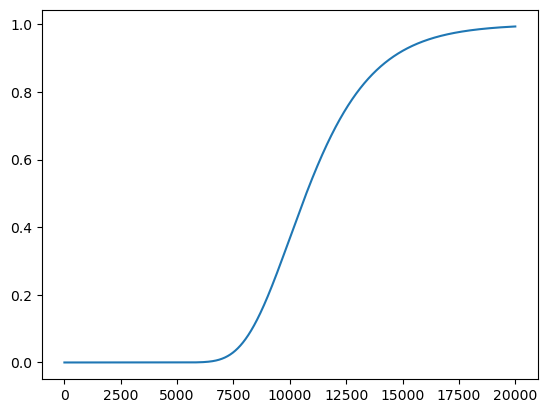

In [9]:
plot(growth_factor_list)
plt.show()


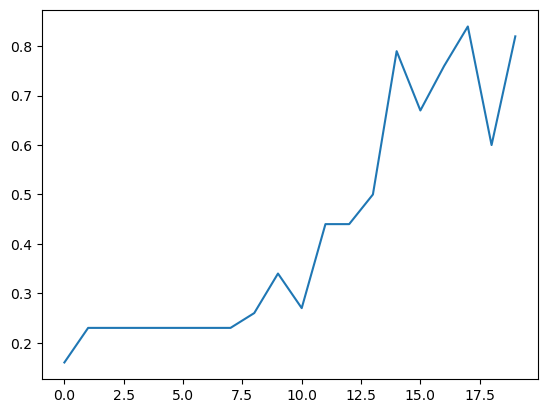

In [10]:
plot(res_hist_test)
plt.show()

In [11]:
# Why does beta get replaced by the numpy function??
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

In [12]:
save_matrices(W, Wvh, Wch, mBv, mBh, b_c, b_v, b_h, mB, date_str, date_time_str)

Matrices saved to output/output/2023-04-19/14-40
